In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# ledgame

`ledgame` is a game focusing on puzzles and labyrinth exploration using the 8x8 LED display on the [Sense HAT](https://www.raspberrypi.org/products/sense-hat/) module for the Raspberry Pi. 
To control the character within the game, the player uses the control stick also present on the Sense Hat module. 
The game's levels are PNG images which are parsed, and each pixel in the image becomes a cell within the game.

Certain pixels in the PNG images, when parsed, result in certain mechanics that have been implemented:

* Black pixels become floors
* White pixels become walls
* Blue pixels become the player
    * **Note:** If several blue pixels exists in an image, a random blue pixel is selected as the player's start position
* Gold pixels become gold coins which the player must pick up to clear the level
* Brown pixels become teleports which ports the player to another teleport when stepped on
    * **Note:** If several brown pixels exists in a stage, teleports work in a circle. This means that upon teleporting, the player gets teleported to the next teleporter. Then, upon stepping on the exit teleporter, the player gets teleported to the next in line. 
* Gray pixels become boxes which the player can push around
* Green pixels become keys which the player can pick up
* Purple pixels become doors which are locked until a player tries to unlock it while holding at least one key

We can have a look at the specific colours defined in `ledgame`.

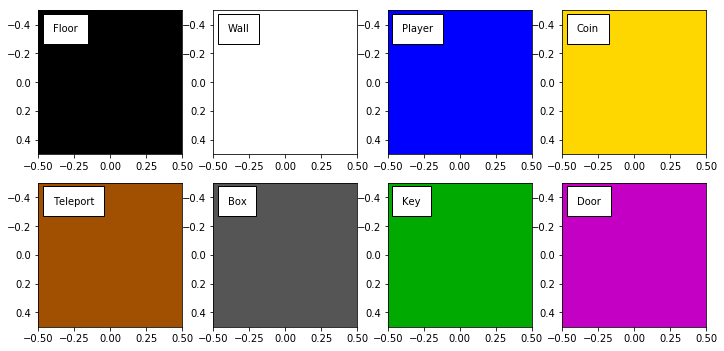

In [2]:
import ledgame

colors = [ledgame.BLACK, ledgame.WHITE, ledgame.BLUE, ledgame.GOLD, 
    ledgame.BROWN, ledgame.GRAY, ledgame.GREEN, ledgame.PURPLE]
labels = ["Floor", "Wall", "Player", "Coin", 
    "Teleport", "Box", "Key", "Door"]

plt.figure(figsize=(12, 9))

for i in range(len(colors)):
    plt.subplot(3, 4, i+1)
    
    plt.imshow(np.array(colors[i]).reshape((1, 1, 3)), interpolation="none")
    plt.text(-0.4,-0.35, labels[i], bbox={'facecolor': 'white', 'pad': 10})

plt.show()

## Developing on the computer

One of the initial issues in the project was a lack of an easy way to represent the game
on a computer, to simulate the 8x8 LED display and the inputs from the control stick. There exists an emulator [online](https://trinket.io/sense-hat), however this was not suitable to develop on due to a lack of collaborative functionality and version control. There is also a Python module names [sense-emu](https://sense-emu.readthedocs.io/en/v1.1/), but this proved to be very difficult to install and run on platforms other than on Linux distributions.

Considering this, a simple emulator module was created to cover the group's needs. The module was named `notpi`, and would need the following to be suitable:

* Simple installation
* Works on Windows, MacOS, and Linux
* Graphical representation of 8x8 LED display
* Can use keyboard keys to act as control stick
* Uses the same function names as the Sense HAT module

### notpi

In order to meet the first four points above, `notpi` depends on [PyGame](https://www.pygame.org/). Since PyGame is cross-platform, and works as an abstraction wrapper for [SDL2](https://www.libsdl.org/) which makes displaying 2D graphics and catching inputs simple.

To meet the last point, `notpi` is designed according to the [Sense HAT Python module](https://pythonhosted.org/sense-hat/api/). This effectively means that the group can develop `ledgame` to use both the Sense HAT Python module and `notpi` with the same code, and the correct module is used depending on the platform.

The following snippet shows exactly how this is possible.

In [8]:
try:
    # use SenseHat if available
    from sense_hat import SenseHat
    pi = SenseHat()
except ImportError:
    # if not, fall back to NotPi
    from notpi import NotPi
    pi = NotPi(init_pygame=False)

print(f"Current backend: {pi.__class__.__name__}")

Current backend: NotPi


We can verify that NotPi works by using the `set_pixels` example from the [Sense HAT API Reference](https://pythonhosted.org/sense-hat/api/#sense-hat-api-reference).

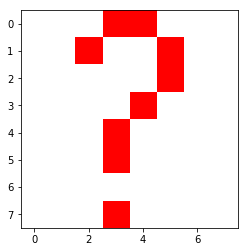

In [9]:
X = [255, 0, 0]  # Red
O = [255, 255, 255]  # White

question_mark = [
O, O, O, X, X, O, O, O,
O, O, X, O, O, X, O, O,
O, O, O, O, O, X, O, O,
O, O, O, O, X, O, O, O,
O, O, O, X, O, O, O, O,
O, O, O, X, O, O, O, O,
O, O, O, O, O, O, O, O,
O, O, O, X, O, O, O, O
]

pi.set_pixels(question_mark)

pixels = np.array(pi.get_pixels())
grid = pixels.reshape((8, 8, 3))
plt.imshow(grid, interpolation="none")
plt.show()

## Game mechanics

TODO: Write about ca

In [10]:
from ledgame.character import Character
from ledgame.world import World
from os import path, listdir

pi = NotPi(init_pygame=False)
basepath = path.dirname(path.abspath(ledgame.__file__))
enabled_levels = path.join(basepath, "levels", "enabled")
worlds = [
    file for file 
    in listdir(enabled_levels) 
    if path.isfile(path.join(enabled_levels, file))
]
world_number = 2

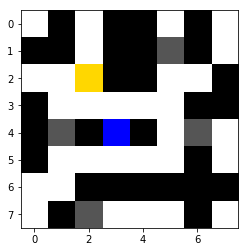

In [6]:
def get_level(filename):
    return path.join(enabled_levels, filename)

def set_level(world_number, char):
    char.total_gold += char.gold
    world = World(get_level(worlds[world_number]))
    char.start(world.player_start)
    return world

def draw(char):
    view = world.view(char)
    pi.set_pixels(view)
    pi.set_pixel(3, 4, char.color)
    pixels = np.array(pi.get_pixels())
    grid = pixels.reshape((8, 8, 3))
    plt.imshow(grid, interpolation="none")
    
char = Character()
world = set_level(world_number, char)
draw(char)

Current gold: 1


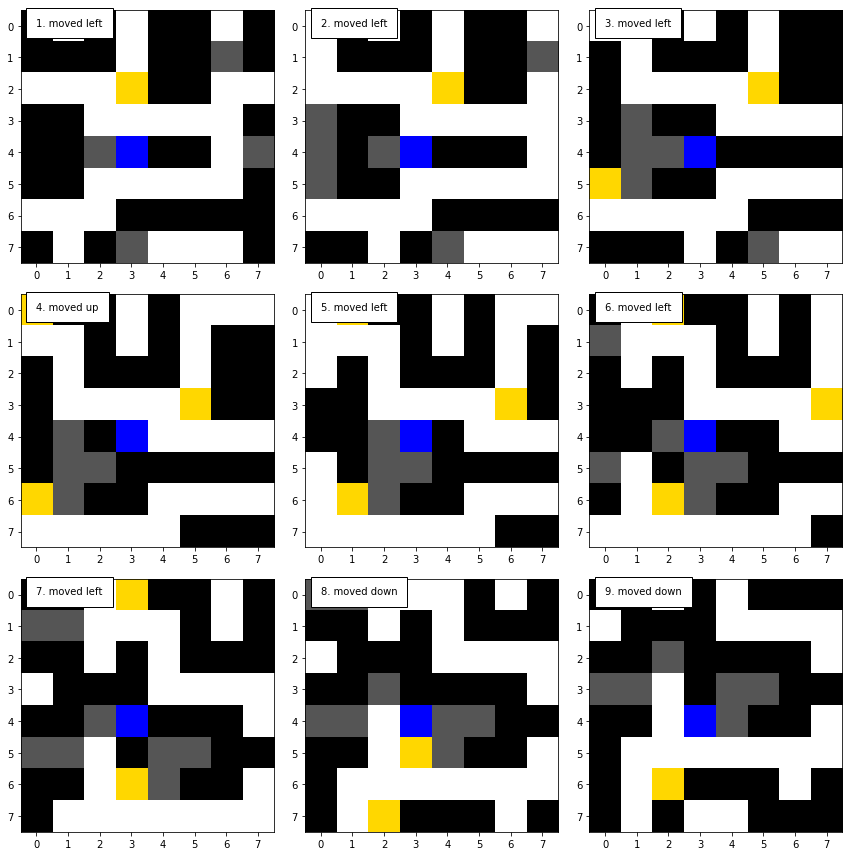

In [7]:
directions = [
    "left",
    "left", # starts moving the first bot
    "left",
    "up",
    "left",
    "left", # moves second box out of the way
    "left",
    "down",
    "down" # gets the gold!
]

plt.figure(figsize=(12, 12))
for i, direction in enumerate(directions):
    plt.subplot(3, 3, i+1)
    char.move(direction, world)
    draw(char)
    plt.text(0, 0, f"{i+1}. moved {direction}", bbox={'facecolor': 'white', 'pad': 10})
    
plt.tight_layout()
plt.show()